# 02. EUNIS Schema Analysis & Overlap

**Goal:**
Before merging the 8+ EUNIS datasets into a single GeoDataFrame, we must verify if they share the same schema (column names and data types).

If they differ significantly, a blind merge will result in a sparse table full of `NaN` values, which is inefficient for Google Earth Engine ingestion.

**Steps:**
1. Load the first row of every downloaded GeoJSON file (smart sampling).
2. Extract column names from each.
3. Compute the **intersection** (common columns) and **union** (all columns).
4. Visualize the overlap using a presence/absence heatmap.
5. Define the strategy for the merge pipeline.

In [2]:
import sys
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Configure plotting style
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_rows', 100)

## 1. Load Data Registry
We scan the `data/raw/eunis` directory to find all downloaded datasets.

In [3]:
raw_dir = Path("../data/raw/eunis")
files = sorted(list(raw_dir.glob("*.geojson")))

print(f"Found {len(files)} datasets in {raw_dir}")

if not files:
    raise FileNotFoundError("No files found! Did you run '01_download_data.ipynb'?")

Found 8 datasets in ../data/raw/eunis


## 2. Extract Schemas
Instead of loading gigabytes of data, we use `rows=1` to read just the header and the first feature. This makes the analysis instant.

In [4]:
schema_registry = {}
dtypes_registry = {}

print("Scanning schemas...")
for p in files:
    # Read only the first row to get columns/types efficiently
    try:
        # Note: rows=1 allows us to see columns without parsing the whole file
        gdf_sample = gpd.read_file(p, rows=1)
        
        # Clean filename for display (e.g. "EUNIS_Marine_Habitat" -> "Marine_Habitat")
        clean_name = p.stem.replace("EUNIS_", "")
        
        schema_registry[clean_name] = set(gdf_sample.columns)
        dtypes_registry[clean_name] = gdf_sample.dtypes
        
    except Exception as e:
        print(f"⚠️ Error reading {p.name}: {e}")

print(f"Successfully scanned {len(schema_registry)} schemas.")

Scanning schemas...
Successfully scanned 8 schemas.


## 3. Analyze Intersection
Let's calculate exactly which columns are shared across *all* datasets and which are unique to specific ones.

In [5]:
all_columns = set().union(*schema_registry.values())
common_columns = set.intersection(*schema_registry.values())
divergent_columns = all_columns - common_columns

print(f"Total Unique Columns: {len(all_columns)}")
print(f"Common Columns ({len(common_columns)}):")
print(sorted(list(common_columns)))

print(f"\nDivergent Columns ({len(divergent_columns)}):")
print(sorted(list(divergent_columns)))

Total Unique Columns: 16
Common Columns (6):
['OBJECTID', 'PLOTOBSID', 'PRECISION', 'Plot', 'YEAR', 'geometry']

Divergent Columns (10):
['Code_', 'Code_2018', 'Code_tif', 'Descriptio', 'Description', 'HabitatCod', 'Level', 'Name', 'Name_', 'Name_2018']


## 4. Visualization: Schema Heatmap
A heatmap is the fastest way to spot outliers.
- **X-Axis:** Column Names
- **Y-Axis:** Dataset Names
- **Color:** Blue = Present, White = Absent

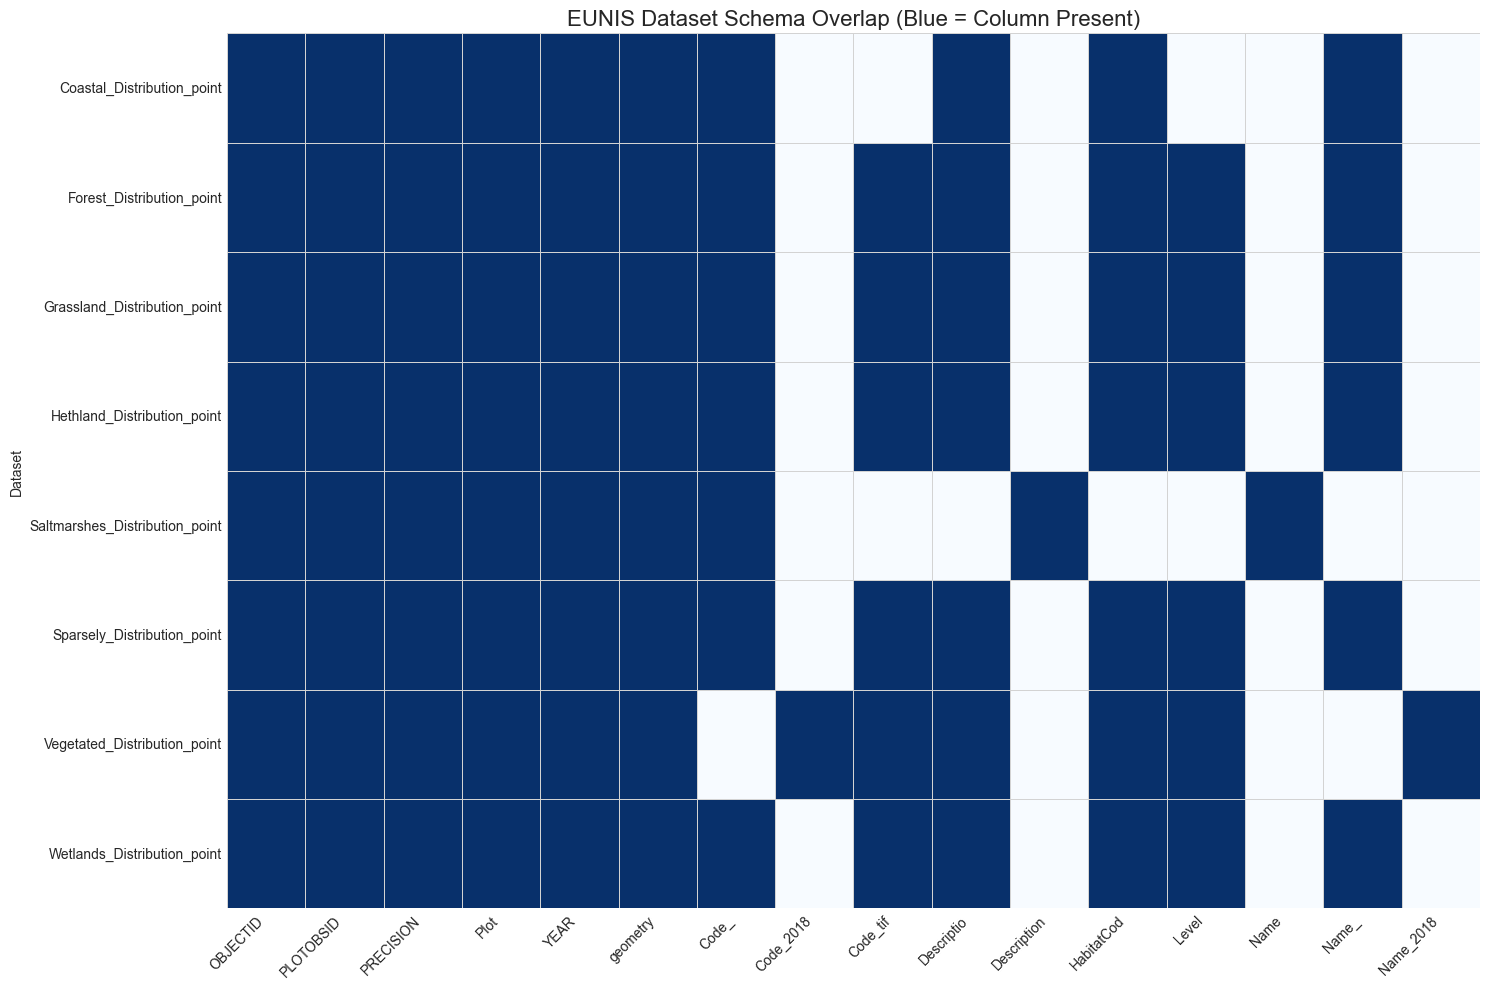

In [6]:
# Build a boolean matrix: True if column exists in dataset
matrix_data = []
for name, cols in schema_registry.items():
    row = {col: (col in cols) for col in all_columns}
    row['Dataset'] = name
    matrix_data.append(row)

df_matrix = pd.DataFrame(matrix_data).set_index("Dataset")

# Sort columns: Put common ones on the left, divergent on the right
sorted_cols = sorted(list(common_columns)) + sorted(list(divergent_columns))
df_matrix = df_matrix[sorted_cols]

# Plot
plt.figure(figsize=(15, 10))
sns.heatmap(df_matrix, cmap="Blues", cbar=False, linewidths=0.5, linecolor='lightgray')
plt.title("EUNIS Dataset Schema Overlap (Blue = Column Present)", fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

## 5. Detailed Divergence Report
If we simply drop the divergent columns, what are we losing? Let's check the specific fields that are missing from some files.

In [7]:
if divergent_columns:
    print("--- Divergence Report ---")
    for col in sorted(list(divergent_columns)):
        # Calculate how many datasets have this column
        present_in = df_matrix[col].sum()
        total = len(df_matrix)
        
        # If it's in most files (e.g., > 90%), we might want to keep it and fill N/A
        status = "Rare" if present_in < 5 else "Common"
        if present_in > (total * 0.8): status = "Dominant"
            
        print(f"Column '{col}': present in {present_in}/{total} files ({status})")
        
        # Optional: Print which files are MISSING a 'Dominant' column
        if status == "Dominant":
            missing_files = df_matrix.index[~df_matrix[col]].tolist()
            print(f"   └── Missing in: {missing_files}")

--- Divergence Report ---
Column 'Code_': present in 7/8 files (Dominant)
   └── Missing in: ['Vegetated_Distribution_point']
Column 'Code_2018': present in 1/8 files (Rare)
Column 'Code_tif': present in 6/8 files (Common)
Column 'Descriptio': present in 7/8 files (Dominant)
   └── Missing in: ['Saltmarshes_Distribution_point']
Column 'Description': present in 1/8 files (Rare)
Column 'HabitatCod': present in 7/8 files (Dominant)
   └── Missing in: ['Saltmarshes_Distribution_point']
Column 'Level': present in 6/8 files (Common)
Column 'Name': present in 1/8 files (Rare)
Column 'Name_': present in 6/8 files (Common)
Column 'Name_2018': present in 1/8 files (Rare)


## 6. Conclusion & Strategy

Based on the heatmap and report above, we need to decide on a merge strategy for the pipeline.

**Standard Strategy:**
1. **Keep** all `Common Columns` (Intersection).
2. **Drop** `Rare` divergent columns (to save space).
3. **Keep & Fill** `Dominant` divergent columns (if valuable for analysis).

The pipeline script (`run_pipeline.py`) will implement this logic to produce a clean `eunis_merged.geojson`.